# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np

training_file = "./traffic-signs-data/train.p"
#validation_file="./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
#with open(validation_file, mode='rb') as f:
#    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
#X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [ ]:
# y_train = np.append(y_train, [43], axis = 0)
# train['lables'] = y_train
# with open(training_file, mode='wb') as f:
#     pickle.dump(train, f)
# train['labels'][39209]

In [ ]:
# data = {'features': [ ], 'labels': [ ]}
# image = data['features']
# image.append([255, 255, 0])
# X_train.shape
# image = X_train[39208]
# X_train.shape
# X_train = np.append(X_train, [image], axis = 0)
# print(X_train.shape)

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np

n_train = X_train.shape[0]
#n_valid = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]

n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
#print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 46224
Number of testing examples = 13295
Image data shape = (32, 32, 3)
Number of classes = 51


### Include an exploratory visualization of the dataset

IndexError: index 210 is out of bounds for axis 0 with size 210

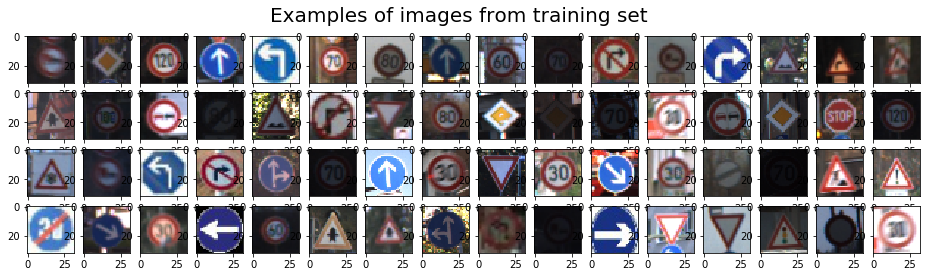

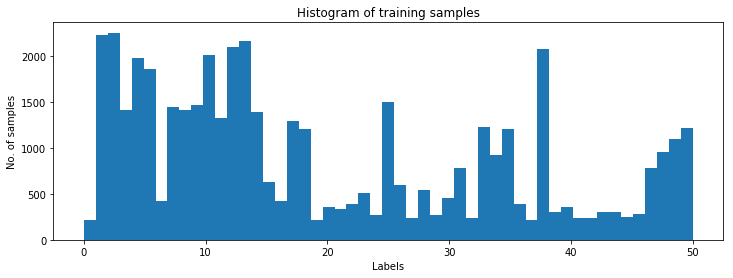

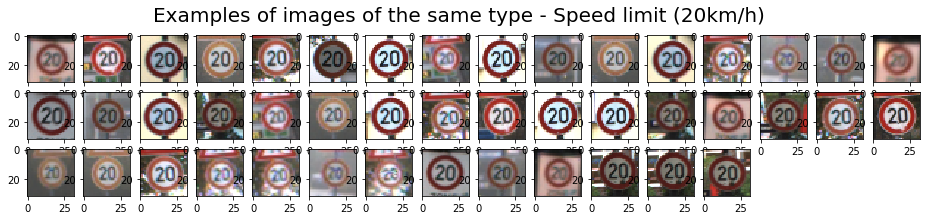

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random 

# Visualizations will be shown in the notebook.
get_ipython().magic('matplotlib inline')

def draw_images_examples(image_array, grid_x, grid_y, title):
    fig = plt.figure(figsize=(grid_x,grid_y))
    fig.suptitle(title, fontsize=20)
 
    for i in range(1,grid_y*grid_x+1):
        index = random.randint(0, len(image_array))
        image = image_array[index].squeeze()
       
        plt.subplot(grid_y,grid_x,i)
        plt.imshow(image)
        
draw_images_examples(X_train, 16, 4, 'Examples of images from training set')
    

fig = plt.figure(figsize=(12,4))
n, bins, patches = plt.hist(y_train, n_classes)
plt.xlabel('Labels')
plt.ylabel('No. of samples')
plt.title('Histogram of training samples')

X_train_one_label = X_train[np.where(y_train==0)]
draw_images_examples(X_train_one_label, 16, 4, 'Examples of images of the same type - Speed limit (20km/h)')

## Step 2: Design and Test a Model Architecture

# Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.

### Equalize histograms of training samples - by generation of additional, transformed images

100%|███████████████████████████████████████████████████████████████████████████████████████████| 51/51 [07:54<00:00,  9.30s/it]


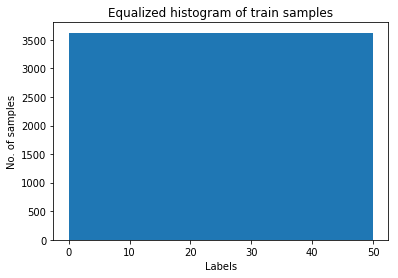

Train set increased from 46224 to 184824


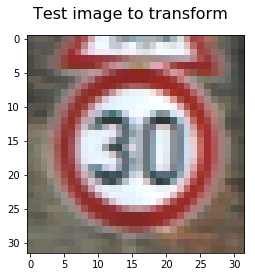

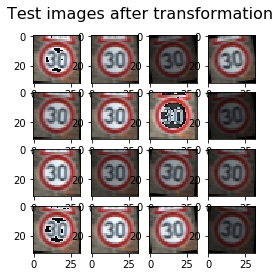

In [4]:
from tqdm import tqdm
from scipy import ndimage
import cv2 

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img):    
    ang_range = 25
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))    
    img = augment_brightness_camera_images(img)
    
    return img

def get_random_image_of_given_label(images_set, labels_set, label):
    image_indexes = np.where(labels_set == label)
    rand_index = random.randint(0, np.bincount(labels_set)[label] - 1)
    return images_set[image_indexes][rand_index]

def equalize_samples_set(X_set, y_set):
    labels_count_arr = np.bincount(y_set)
    labels_bins = np.arange(len(labels_count_arr))
    
    ind = 0    
   
    for label in tqdm(labels_bins):        
        labels_no_to_add =  int(np.mean(labels_count_arr)) * 4 - labels_count_arr[label]
        
        ind = ind + 1
        X_temp = []
        y_temp = []
        
        for num in range(labels_no_to_add):      
            rand_image = get_random_image_of_given_label(X_set, y_set, label)
            X_temp.append(transform_image(rand_image))
            y_temp.append(label)            
   
        X_set = np.append(X_set, np.array(X_temp), axis=0)
        y_set = np.append(y_set, np.array(y_temp), axis=0)
        
    return X_set, y_set


X_train, y_train = equalize_samples_set(X_train, y_train)

n, bins, patches = plt.hist(y_train, n_classes)
plt.xlabel('Labels')
plt.ylabel('No. of samples')
plt.title('Equalized histogram of train samples')
plt.show()

print("Train set increased from {} to {}".format(n_train,X_train.shape[0]))

fig=plt.figure()
fig.suptitle('Test image to transform', fontsize=16)
plt.imshow(X_train[1000])

grid_len = 4
fig=plt.figure(figsize=(grid_len,grid_len))
fig.suptitle('Test images after transformation', fontsize=16)
 
for i in range(1,grid_len*grid_len+1):
    image = transform_image(X_train[1000])
    plt.subplot(grid_len,grid_len,i)
    plt.imshow(image)

### Image normalization and grayscale conversion

100%|██████████████████████████████████████████████████████████████████████████████████| 13295/13295 [00:01<00:00, 10748.83it/s]


Sample image dimension BEFORE processing: (32, 32, 3)
Sample image dimension AFTER processing: (32, 32, 1)


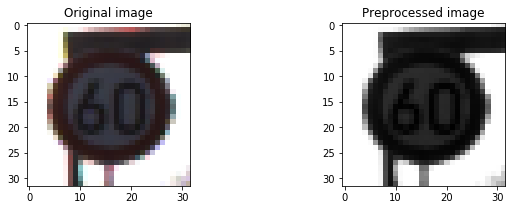

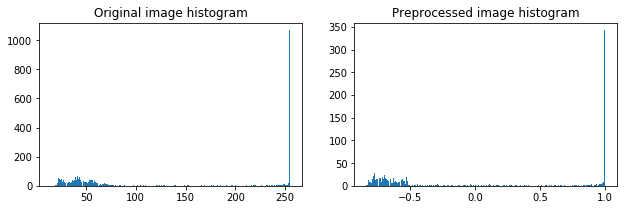

In [5]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="/cpu:0"
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def grayscale(img):    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)[:,:,None]

def normalize(value):
    return value / 255 * 2 - 1

def preprocess_image(image):
    img = grayscale(image)
    img = normalize(img)
    return img

from tqdm import tqdm
def preprocess_batch(images):
    imgs = np.zeros(shape=images.shape)
    processed_image_depth = preprocess_image(images[0]).shape[2]
    imgs = imgs[:,:,:,0:processed_image_depth]
    for i in tqdm(range(images.shape[0])):
        imgs[i] = preprocess_image(images[i])        
    return imgs

X_train_processed = preprocess_batch(X_train)
#X_valid_processed = preprocess_batch(X_valid)
X_test_processed = preprocess_batch(X_test)

no_test_image = 10000

sample_image = X_train[no_test_image-5000]
sample_image_processed = grayscale(X_train[no_test_image-5000])
fig=plt.figure(figsize=(16,3))
sub=plt.subplot(131)
sub.set_title("Original image")
plt.imshow(sample_image)
sub=plt.subplot(132)
sub.set_title("Preprocessed image")
plt.imshow(sample_image_processed.squeeze(), cmap='gray')

print("Sample image dimension BEFORE processing: {}".format(sample_image.shape))
print("Sample image dimension AFTER processing: {}".format(sample_image_processed.shape))

image_depth = X_train_processed.shape[3]

sample_image = X_train[no_test_image-5000]
dim1 = sample_image.shape[0]
dim2 = sample_image.shape[1]
dim3 = sample_image.shape[2]
sample_image_reshaped = np.reshape(sample_image, dim1*dim2*dim3)
plt.figure(figsize=(16,3))
sub=plt.subplot(131)
sub.set_title("Original image histogram")
n, bins, patches = plt.hist(sample_image_reshaped, 255)

sample_image_processed = X_train_processed[no_test_image-5000]
dim1 = sample_image_processed.shape[0]
dim2 = sample_image_processed.shape[1]
dim3 = sample_image_processed.shape[2]
sample_image_processed_reshaped = np.reshape(sample_image_processed, dim1*dim2*dim3)
sub=plt.subplot(132)
sub.set_title("Preprocessed image histogram")
n, bins, patches = plt.hist(sample_image_processed_reshaped,255)

### Model Architecture

In [6]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="/cpu:0"
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 200
BATCH_SIZE = 32

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, image_depth, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
        
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


x = tf.placeholder(tf.float32, (None, 32, 32, image_depth))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.003

logits = LeNet(x)

varss = tf.trainable_variables() 
lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in varss
                    if '_b' not in v.name ]) * 0.0001

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy) + lossL2
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)



correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Training...

EPOCH; 1; Loss; 0.26735
EPOCH; 2; Loss; 0.15094
EPOCH; 3; Loss; 0.14093
EPOCH; 4; Loss; 0.13677
EPOCH; 5; Loss; 0.14869
EPOCH; 6; Loss; 0.27378
EPOCH; 7; Loss; 0.15632
EPOCH; 8; Loss; 0.26831
EPOCH; 9; Loss; 0.25484
EPOCH; 10; Loss; 0.20915
EPOCH; 11; Loss; 0.15565
EPOCH; 12; Loss; 0.13079
EPOCH; 13; Loss; 0.16569
EPOCH; 14; Loss; 0.12791
EPOCH; 15; Loss; 0.16448
EPOCH; 16; Loss; 0.13436
EPOCH; 17; Loss; 0.14234
EPOCH; 18; Loss; 0.12596
EPOCH; 19; Loss; 0.22281
EPOCH; 20; Loss; 0.12227
EPOCH; 21; Loss; 0.20582
EPOCH; 22; Loss; 0.52431
EPOCH; 23; Loss; 0.12075
EPOCH; 24; Loss; 0.13116
EPOCH; 25; Loss; 0.23138
EPOCH; 26; Loss; 0.11860
EPOCH; 27; Loss; 0.11745
EPOCH; 28; Loss; 0.56638
EPOCH; 29; Loss; 0.36763
EPOCH; 30; Loss; 0.11723
EPOCH; 31; Loss; 0.15387
EPOCH; 32; Loss; 0.11658
EPOCH; 33; Loss; 0.19503
EPOCH; 34; Loss; 0.28032
EPOCH; 35; Loss; 0.25901
EPOCH; 36; Loss; 0.20137
EPOCH; 37; Loss; 0.16369
EPOCH; 38; Loss; 0.21655
EPOCH; 39; Loss; 0.11458
EPOCH; 40; Loss; 0.13

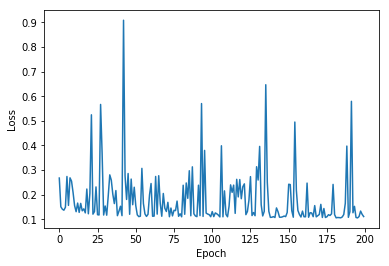

In [7]:
from sklearn.utils import shuffle
import os
FLAGS = None

cost_arr = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_processed)
    tf.train.write_graph(sess.graph.as_graph_def(), "./", "input_graph.pb")
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_processed, y_train = shuffle(X_train_processed, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_processed[offset:end], y_train[offset:end]
            to, cost = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y})
        print("EPOCH; {}; Loss; {:.5f}".format(i+1, cost))
        cost_arr.append(cost)
        checkpoint_prefix = os.path.join("./", "saved_checkpoint")
        saver.save(sess, checkpoint_prefix, global_step=0, latest_filename="trafficsignckpt")
      
        
    saver.save(sess, './lenet')
    print("Model saved")


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_processed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
plt.plot(cost_arr)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show() 

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

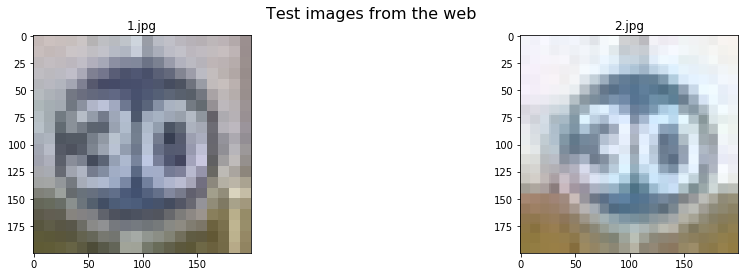

In [9]:
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
import cv2
import numpy as np
def grayscale(img):    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)[:,:,None]

def normalize(value):
    return value / 255 * 2 - 1

def preprocess_image(image):
    img = grayscale(image)
    img = normalize(img)
    return img

img_folder = './examples/'
test_images = []
#test_responses = [1, 43, 22, 18, 38, 17, 47, 23]
test_responses = [44,44]
fig = plt.figure(figsize=(16,4))
fig.suptitle('Test images from the web', fontsize=16)

# image = mpimg.imread(img_folder+"noEntry.jpg")
# print(image[39][38][])
cnt = 0
for img_name in os.listdir(img_folder):
    image = mpimg.imread(img_folder+img_name)
    image_to_show = cv2.resize(image, (200, 200), interpolation = cv2.INTER_AREA)
    image = cv2.resize(image, (32, 32), interpolation = cv2.INTER_AREA)
    cnt = cnt+1
    sub=plt.subplot(1,2,cnt)
    sub.set_title(img_name)
    plt.imshow(image_to_show)
    image = preprocess_image(image) 
    test_images.append(image)
    
    
test_images = np.array(test_images)

### Predict the Sign Type for Each Image

In [10]:
import tensorflow as tf
pred_val = tf.argmax(logits, 1)
pred_softmax = tf.nn.softmax(logits)
pred_topFive = tf.nn.top_k(pred_softmax, k=5)
    
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    saver.restore(sess, "lenet")
    pred_val_out, pred_topFive_out = sess.run( [pred_val, pred_topFive], feed_dict={x:  test_images, y: test_responses})
    
print("Predicted Labels")
print(pred_val_out)
print()


with open('signnames.csv') as csvfile:
    next(csvfile) # ignore header
    a = [ row.strip().split(',') for row in csvfile]
    signnames_dict = dict((data[0],data[1:]) for data in a)
    
cnt = 0
correct_cnt = 0
for i in pred_val_out:
    correctness = "Correct"
    if test_responses[cnt] == i:
        correctness = "Correct"
        correct_cnt = correct_cnt + 1
    else:
        correctness = "Not correct!"
      
    print("{} - {} -> {}".format(i, signnames_dict[str(i)], correctness))
    cnt = cnt + 1

INFO:tensorflow:Restoring parameters from lenet
Predicted Labels
[44 44]

44 - ['Minimum speed 30'] -> Correct
44 - ['Minimum speed 30'] -> Correct


### Analyze Performance

In [11]:
print("Accuracy for the tested images equals: {:.2f} %".format(correct_cnt/cnt*100)) 

Accuracy for the tested images equals: 100.00 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

Top 5 softmax probabilities for fach test image
TopKV2(values=array([[  9.99956727e-01,   3.87113978e-05,   3.70866587e-06,
          2.86730682e-07,   2.20405184e-07],
       [  9.99759853e-01,   2.30848120e-04,   5.92028255e-06,
          1.36239089e-06,   4.00102039e-07]], dtype=float32), indices=array([[44, 45, 34, 50, 36],
       [44, 45, 34, 39, 36]]))


IndexError: index 2 is out of bounds for axis 0 with size 2

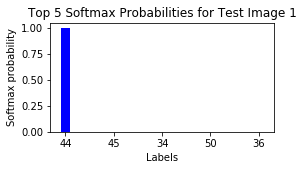

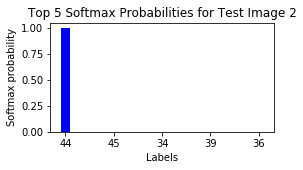

In [12]:
print('Top 5 softmax probabilities for fach test image')
print(pred_topFive_out)

top_k_values = pred_topFive_out[0]
top_k_indices = pred_topFive_out[1]

ind = np.arange(5) 

for i in range(6):
    plt.figure(figsize=(4,2))
    values = top_k_values[i]
    plt.bar(ind, values, 0.2, color='b')
    plt.ylabel('Softmax probability')
    plt.xlabel('Labels')
    plt.title('Top 5 Softmax Probabilities for Test Image {}'.format(str(i+1)))
    plt.xticks(ind, tuple(top_k_indices[i]))

plt.show()